# Dataset Class Distribution & Anomaly Analysis

This notebook analyzes the class balance of the dataset, identifies rare classes, and checks for structural anomalies (duplicates, uncleaned suffixes, empty folders).

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
DATA_DIR = '../data/release/agri_foundation_v1/data' # Adjust if needed
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tif', '.tiff'}

print(f"Analyzing dataset at: {DATA_DIR}")

Analyzing dataset at: ../data/release/agri_foundation_v1/data


In [2]:
def get_class_counts(data_dir):
    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} not found.")
        return pd.DataFrame(columns=['Class', 'Count'])
        
    class_counts = {}
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    
    print(f"Found {len(classes)} classes.")
    
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        # Count valid image files only
        count = len([f for f in os.listdir(cls_path) 
                     if os.path.isfile(os.path.join(cls_path, f)) 
                     and os.path.splitext(f)[1].lower() in IMAGE_EXTENSIONS])
        class_counts[cls] = count
        
    return pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

df = get_class_counts(DATA_DIR)
df.head()

Found 167 classes.


,Class,Count
0,apple_black_rot,2654
1,apple_cedar_rust,2200
2,apple_frog_eye_leaf_spot,3181
3,apple_healthy,7658
4,apple_mosaic_virus,178


In [3]:
# Basic Statistics
if not df.empty:
    print(f"Total Images: {df['Count'].sum()}")
    print(f"Average Images per Class: {df['Count'].mean():.2f}")
    print(f"Median Images per Class: {df['Count'].median():.2f}")
    print(f"Min Images: {df['Count'].min()}")
    print(f"Max Images: {df['Count'].max()}")
else:
    print("No data found.")

Total Images: 161581
Average Images per Class: 967.55
Median Images per Class: 187.00
Min Images: 6
Max Images: 13158


In [4]:
# Anomaly Detection: Hygiene Checks
print("--- Anomaly Detection ---")

# 1. Empty Classes
zero_classes = df[df['Count'] == 0]
if not zero_classes.empty:
    print(f"\n[CRITICAL] Found {len(zero_classes)} empty classes (0 images):")
    print(zero_classes['Class'].tolist())
else:
    print("\n[OK] No empty classes found.")

# 2. Uncleaned Suffixes (Normalization Check)
suffixes = ['_google', '_bing', '_baidu', '_plantseg']
flagged_suffixes = []
for cls in df['Class']:
    for s in suffixes:
        if cls.endswith(s):
            flagged_suffixes.append(cls)
            break

if flagged_suffixes:
    print(f"\n[WARNING] Found {len(flagged_suffixes)} classes with raw suffixes (normalization incomplete?):")
    print(flagged_suffixes[:10], "..." if len(flagged_suffixes) > 10 else "")
else:
    print("\n[OK] No classes with known raw suffixes found.")

# 3. Potential Duplicates (Prefix Heuristic)
# Checks if 'Crop_Disease' and 'Crop_Crop_Disease' both exist
classes_set = set(df['Class'])
duplicates = []
for cls in classes_set:
    parts = cls.split('_')
    if len(parts) > 1 and parts[0] == parts[1]:
        simple = '_'.join(parts[1:])
        if simple in classes_set:
            duplicates.append(f"{simple} <-> {cls}")

if duplicates:
    print(f"\n[WARNING] Found {len(duplicates)} potential duplicate pairs (naming inconsistency):")
    for d in duplicates[:10]:
        print("  " + d)
    if len(duplicates) > 10: print("  ...")
else:
    print("\n[OK] No obvious prefix-based duplicates found.")

--- Anomaly Detection ---

[OK] No empty classes found.

[OK] No classes with known raw suffixes found.

[OK] No obvious prefix-based duplicates found.


In [12]:
# Identify Rare Classes
RARE_THRESHOLD = 200
rare_classes = df[df['Count'] < RARE_THRESHOLD].sort_values('Count')

print(f"\nClasses with < {RARE_THRESHOLD} images: {len(rare_classes)}")
if not rare_classes.empty:
    print("Rare Classes List:")
    print(rare_classes.to_string(index=False))


Classes with < 200 images: 85
Rare Classes List:
                                       Class  Count
                            coffee_black_rot      6
                                  peach_rust      8
                          broccoli_ring_spot     10
                           peach_anthracnose     13
                       coffee_brown_eye_spot     14
                         plum_bacterial_spot     16
                    carrot_cercospora_blight     17
                              raspberry_spot     18
                        tobacco_frogeye_spot     21
             pepper_bell_bell_powdery_mildew     27
               pepper_bell_bell_frogeye_spot     29
                       raspberry_fire_blight     31
                              plum_pox_virus     32
                eggplant_phytophthora_blight     33
              cauliflower_bacterial_soft_rot     33
                                   plum_rust     34
                       raspberry_yellow_rust     36
              

In [13]:
# Identify Rare Classes
RARE_THRESHOLD = 500
non_rare_classes = df[df['Count'] >= RARE_THRESHOLD].sort_values('Class')

print(f"\nClasses with >= {RARE_THRESHOLD} images: {len(non_rare_classes)}")
if not non_rare_classes.empty:
    print("Rare Classes List:")
    print(non_rare_classes.to_string(index=False))


Classes with >= 500 images: 55
Rare Classes List:
                                 Class  Count
                       apple_black_rot   2654
                      apple_cedar_rust   2200
              apple_frog_eye_leaf_spot   3181
                         apple_healthy   7658
                  apple_powdery_mildew   1184
                            apple_rust   2251
                            apple_scab   7723
                         basil_healthy    588
                     blueberry_healthy   2662
              cassava_bacterial_blight   1087
          cassava_brown_streak_disease   2189
                  cassava_green_mottle   2386
                       cassava_healthy   2577
                cassava_mosaic_disease  13158
                        cherry_healthy   2620
                 cherry_powdery_mildew   2212
                         citrus_canker    528
                        coffee_healthy    896
                      coffee_unhealthy    735
                        corn_

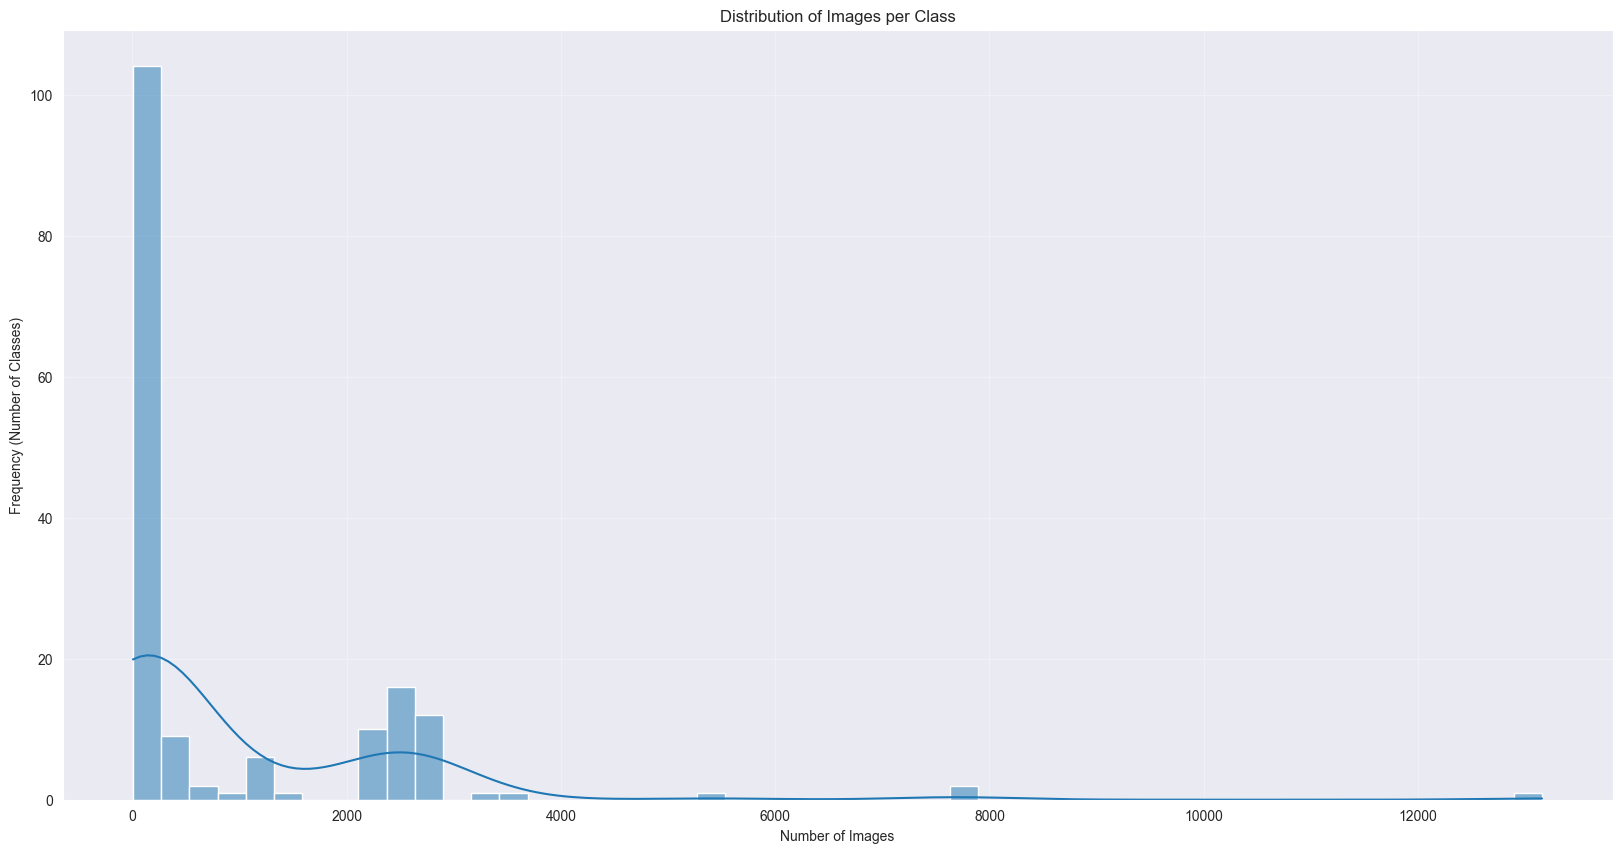

In [6]:
# Visualization
plt.figure(figsize=(20, 10))
sns.histplot(data=df, x='Count', bins=50, kde=True)
plt.title('Distribution of Images per Class')
plt.xlabel('Number of Images')
plt.ylabel('Frequency (Number of Classes)')
plt.grid(True, alpha=0.3)
plt.show()

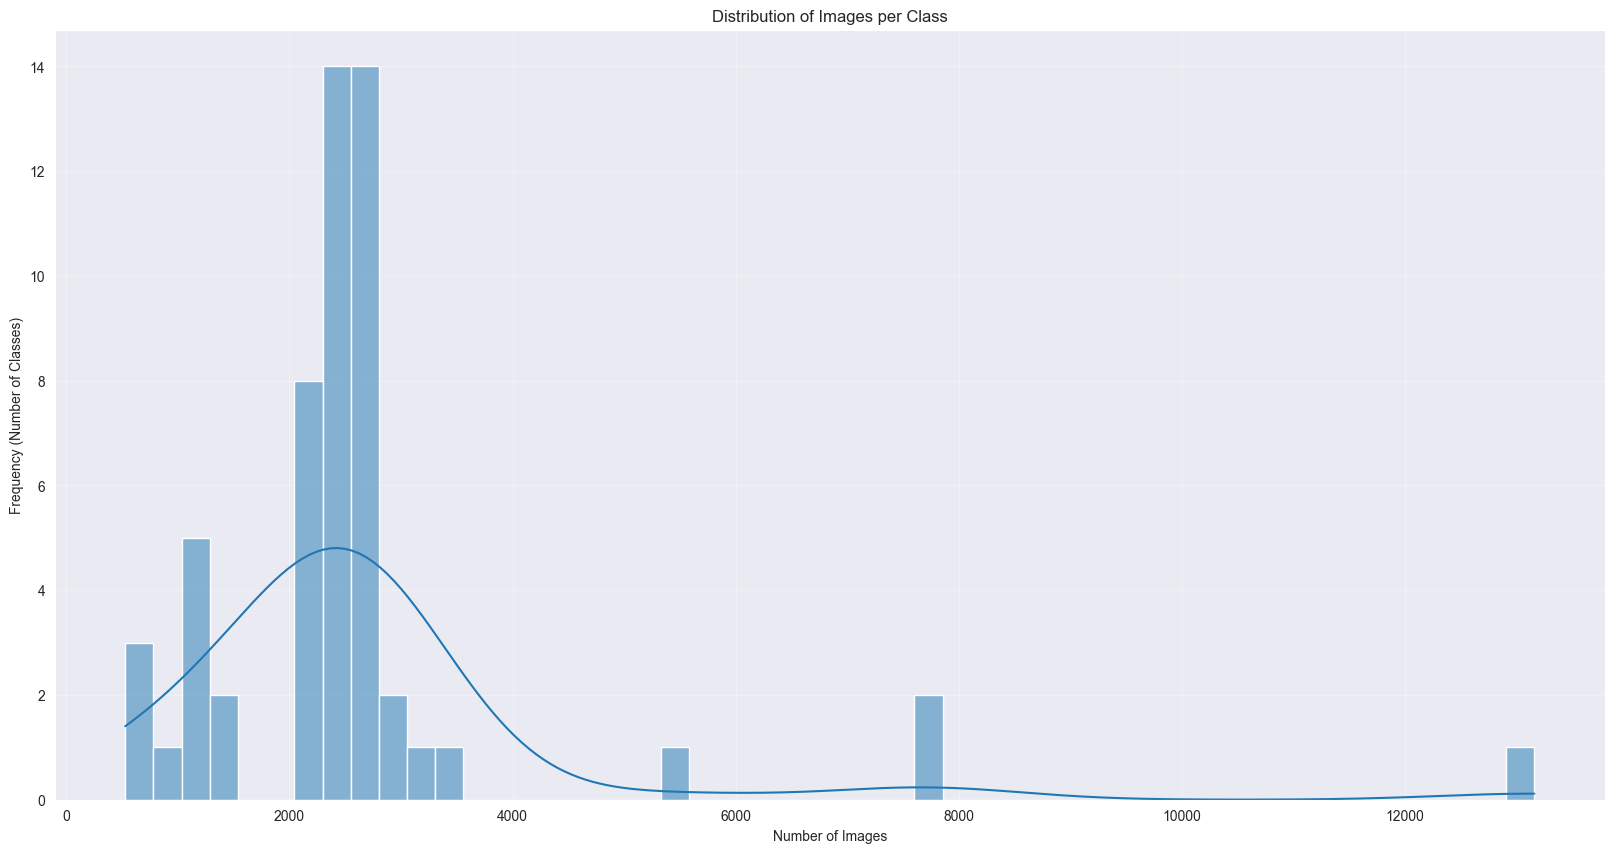

In [14]:
# Visualization
plt.figure(figsize=(20, 10))
sns.histplot(data=non_rare_classes, x='Count', bins=50, kde=True)
plt.title('Distribution of Images per Class')
plt.xlabel('Number of Images')
plt.ylabel('Frequency (Number of Classes)')
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\mouadh\AppData\Local\Temp\ipykernel_3888\1797233236.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20, x='Count', y='Class', ax=axes[0], palette='viridis')
C:\Users\mouadh\AppData\Local\Temp\ipykernel_3888\1797233236.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_20, x='Count', y='Class', ax=axes[1], palette='magma')


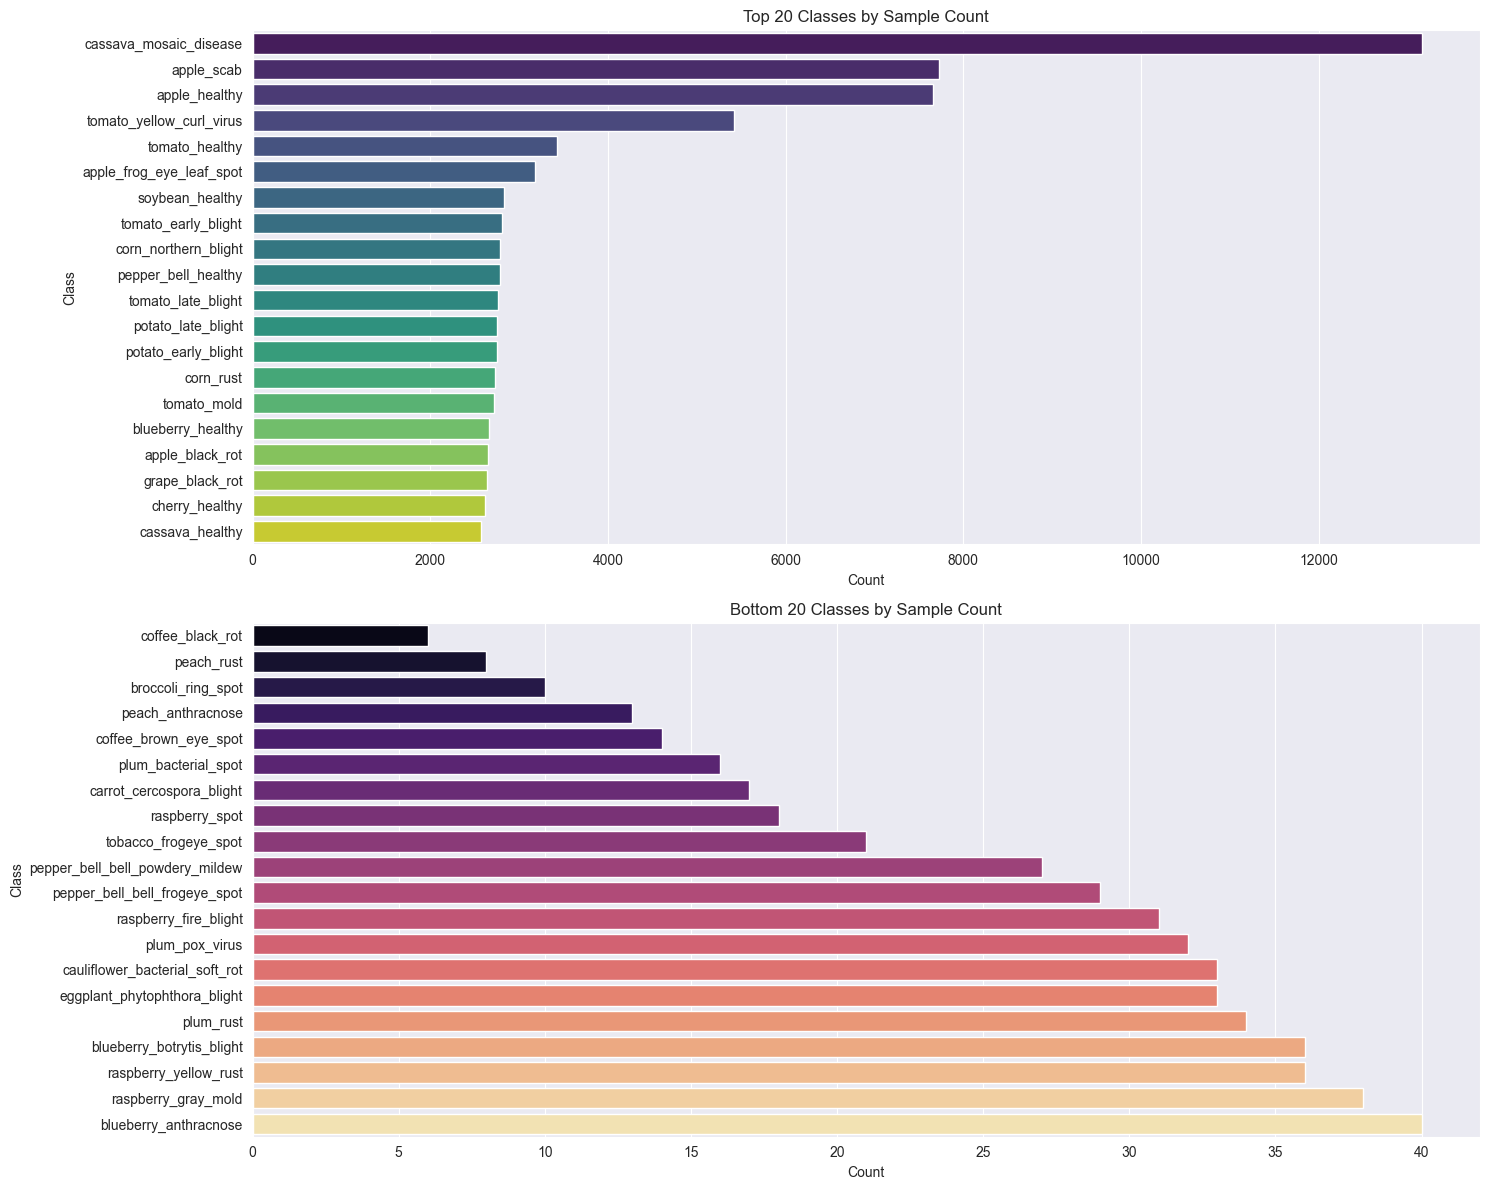

In [7]:
# Detailed Bar Plot (Top 20 and Bottom 20)
if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))

    # Top 20
    top_20 = df.nlargest(20, 'Count')
    sns.barplot(data=top_20, x='Count', y='Class', ax=axes[0], palette='viridis')
    axes[0].set_title('Top 20 Classes by Sample Count')

    # Bottom 20
    bottom_20 = df.nsmallest(20, 'Count')
    sns.barplot(data=bottom_20, x='Count', y='Class', ax=axes[1], palette='magma')
    axes[1].set_title('Bottom 20 Classes by Sample Count')

    plt.tight_layout()
    plt.show()